In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import urllib.request
import zipfile
import os

In [2]:
def loadData(path):
    df = pd.read_csv(path, encoding = 'latin1')
    return df
oes = loadData(path = "./data/preprocessed/oes.csv")
nat = loadData(path = "./data/preprocessed/nat.csv")
occ = loadData(path = "./data/preprocessed/natocc2017.csv")
oes2017 = loadData(path = "./data/preprocessed/oes2017all.csv")

In [3]:
def compareData(df, on, idx):
    df2008 = (df[(df.YEAR == 2008)]
               .rename(columns = {'A_MEDIAN': 'A_MEDIAN_2008',
                                  'JOBS_1000': 'JOBS_1000_2008',
                                  'TOT_EMP': 'TOT_EMP_2008'}))

    df2017 = (df[(df.YEAR == 2017)]
               .rename(columns = {'A_MEDIAN': 'A_MEDIAN_2017',
                                  'JOBS_1000': 'JOBS_1000_2017',
                                  'TOT_EMP': 'TOT_EMP_2017'}))

    compare = pd.merge(left = df2008, right = df2017, how = 'left', on = on)
    compare = (compare
               .assign(SALARY_PCT_GROWTH = lambda x: (x.A_MEDIAN_2017 - x.A_MEDIAN_2008) / x.A_MEDIAN_2008 * 100,
                       JOB_PCT_GROWTH = lambda x: (x.TOT_EMP_2017 - x.TOT_EMP_2008) / x.TOT_EMP_2008 * 100))
    compare = compare.set_index(idx)
    return compare
marketComparison = compareData(oes, ['AREA', 'Market'], 'Market')              
industryComparison = compareData(nat, ['NAICS', 'Industry'], 'Industry')

In [4]:
def plotBar(df, ci, xvar, yvar, xlab, ylab, title):
    barwidth = .8
    sns.set_style("whitegrid")
    plt.figure(figsize=(14,6))
    x = np.arange(df.shape[0]) * 1.08
    y = df[yvar]
    ax = sns.barplot(x=xvar, y=yvar, data=df, palette = "viridis", hue = xvar)    
    ax.set(xticklabels=[])
    ax.set(xlabel = xlab, ylabel = ylab)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    for patch in ax.patches:
        patch.set_width(barwidth)
    ax.set(title = title)
    ax.set_xlim((-.7,10.5))
    ax.title.set(y = 1.3)
    ax.errorbar(x, y, yerr = ci)
    plt.show()

In [5]:
def plotViolin(df, xvar, yvar, xlab, ylab, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(14,6))
    ax = sns.violinplot(x=xvar, y=yvar, data = df, hue=xvar, palette='viridis')
    ax.set(xticklabels=[])
    ax.set(xlabel = xlab, ylabel = ylab)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    ax.set(title = title)
    ax.title.set(y = 1.5)
    plt.show()

In [6]:
def plotTopMarkets(df):
    topSalary = (df[(df.YEAR == 2017)][['Market', 'A_MEDIAN', 'A_MEDIAN_ME']].nlargest(n = 10, columns = 'A_MEDIAN'))
    plotBar(topSalary, topSalary['A_MEDIAN_ME'], "Market", "A_MEDIAN",  "Market", "Median Salary", "Top Markets by Median Salary")
    
    topJobs = (df[(df.YEAR == 2017)][['Market', 'TOT_EMP', 'TOT_EMP_ME']].nlargest(n = 10, columns = 'TOT_EMP'))
    plotBar(topJobs, topJobs['TOT_EMP_ME'],"Market", "TOT_EMP",  "Market", "Total Employment", "Top Markets by C&M Employment")    

In [7]:
def plotTopIndustries(df):
    topSalary = (df[(df.YEAR == 2017)][['Industry', 'A_MEDIAN', 'A_MEDIAN_ME']].nlargest(n = 10, columns = 'A_MEDIAN'))
    plotBar(topSalary, topSalary['A_MEDIAN_ME'], "Industry", "A_MEDIAN",  "Industry", "Median Salary", "Top Industries by Median Salary")
    
    topJobs = (df[(df.YEAR == 2017)][['Industry', 'TOT_EMP', 'TOT_EMP_ME']].nlargest(n = 10, columns = 'TOT_EMP'))
    plotBar(topJobs, topJobs['TOT_EMP_ME'], "Industry", "TOT_EMP",  "Industry", "Total Employment", "Top Industries by C&M Employment") 

In [8]:
def plotTopOccupations(occ, salary):
    plotViolin(salary, "Occupation", "A_MEDIAN",  "Occupation", "Median Salary", "Median Salary by Occupation")    
    topJobs = (occ[['Occupation', 'TOT_EMP', 'TOT_EMP_ME']].nlargest(n = 10, columns = 'TOT_EMP'))
    plotBar(topJobs, topJobs['TOT_EMP_ME'], "Occupation", "TOT_EMP",  "Occupation", "Total Employment", "Top Occupations by C&M Employment") 

In [9]:
def plotTopGrowth(df, size, title):
    # Obtain data for appropriate data set and employment market size
    cols = ['TOT_EMP_2008', 'TOT_EMP_2017']
    n = (df.shape[0])
    topGrowth = (df
                 .nlargest(int(n * size / 3), columns = 'TOT_EMP_2017')
                 .nlargest(5, columns = 'JOB_PCT_GROWTH')
                 .drop(df.columns.difference(cols), axis = 1, inplace = False)
                 .apply(pd.to_numeric, errors = 'ignore')
                 .rename(columns = {'TOT_EMP_2008': '2008',
                                    'TOT_EMP_2017': '2017'})
                 .transpose())
    ax = topGrowth.plot(topGrowth.index.name, topGrowth.columns, figsize=(14,6), title = title)
    ax.legend(loc='upper left')
    plt.show()

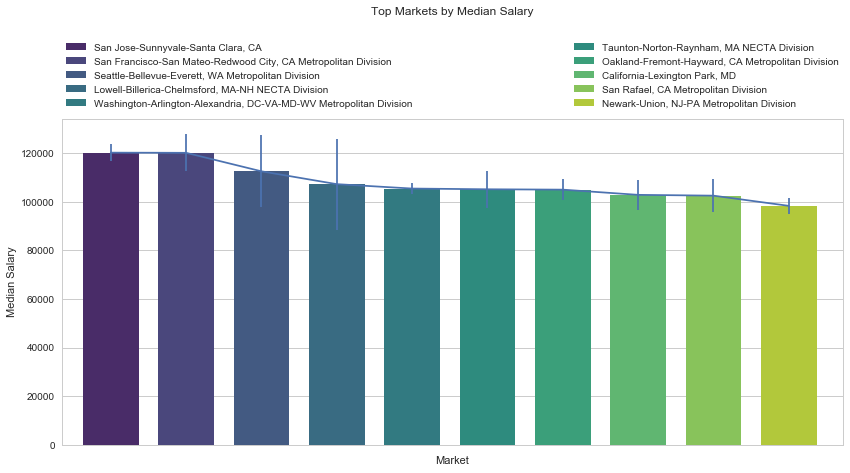

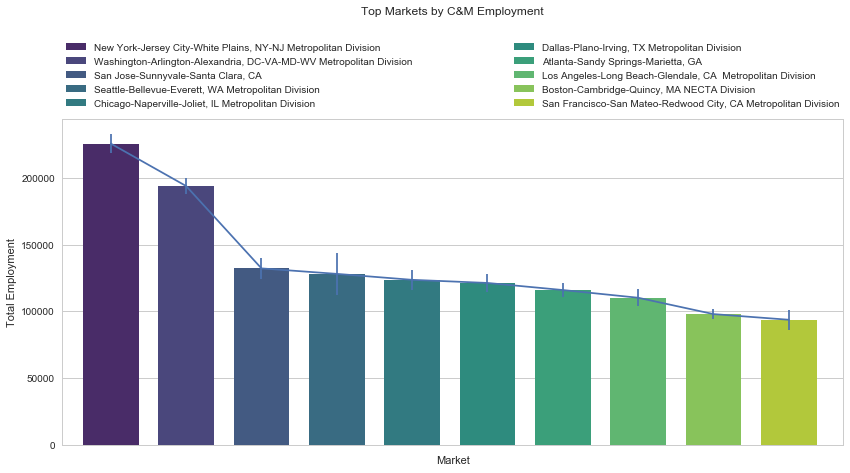

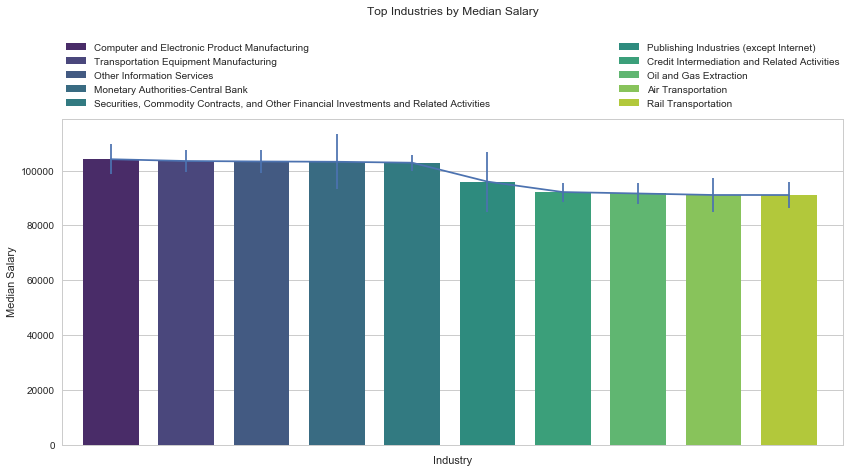

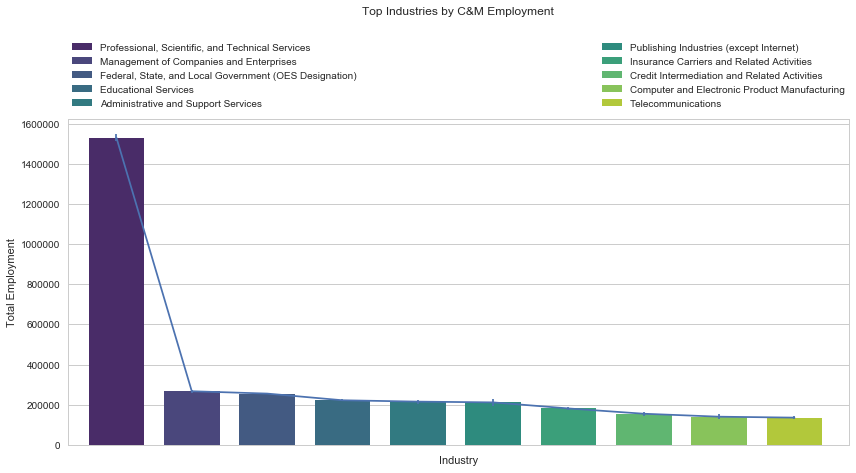

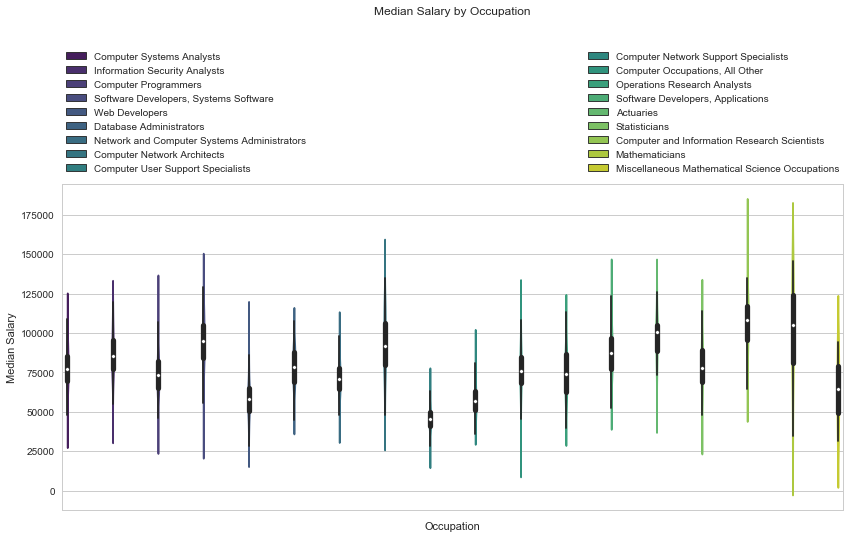

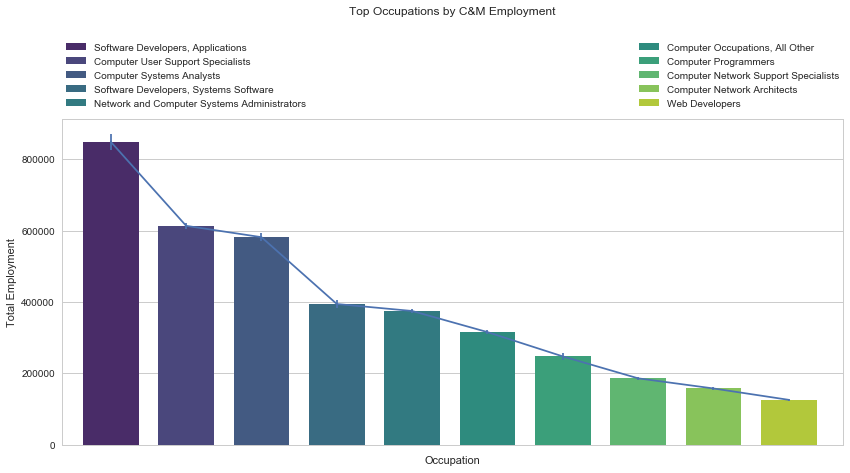

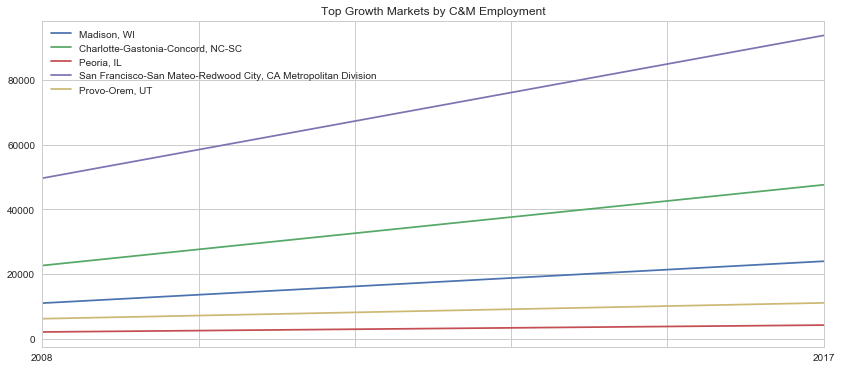

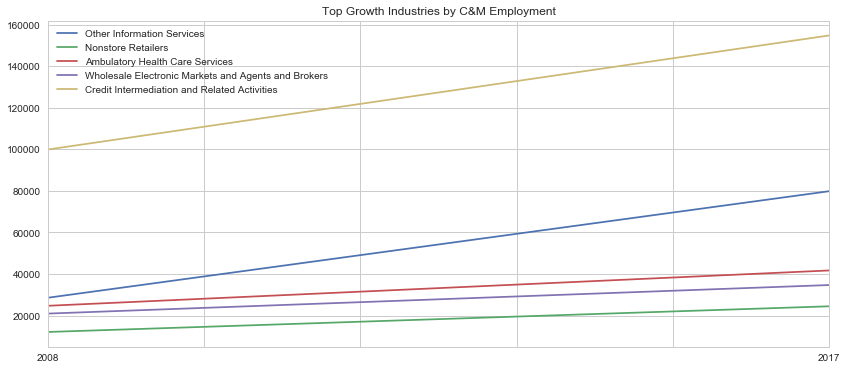

In [10]:
plotTopMarkets(oes)
plotTopIndustries(nat)
plotTopOccupations(occ, oes2017)
plotTopGrowth(marketComparison, size = 1, title = "Top Growth Markets by C&M Employment")
plotTopGrowth(industryComparison, size = 1, title = "Top Growth Industries by C&M Employment")